In [24]:
import itertools
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from scipy.stats import anderson, kstest, kurtosis, skew
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, LeaveOneOut, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

pd.set_option('display.max_colwidth', 500)
pd.set_option('display.float_format', '{:.6f}'.format)

In [4]:
path = '/Users/omercanmisirlioglu/Desktop/TUDO DS SE3/Case Studies/Computer Experiments/DesignMatrixLHS_out.xlsx'
df = pd.read_excel(path)
df

,E_mem,nu_mem,sigma_mem,sigma_edg,sigma_sup,f_mem,sigma_mem_max
0,832131.527991,0.408971,2537.821021,350518.891768,322498.800990,0.546345,5106.868826
1,628520.032612,0.387587,4191.284354,259467.941131,438734.553661,0.327139,4967.665523
2,650861.600961,0.411778,3245.317622,311392.712373,447183.839098,0.328177,4741.755732
3,667768.345534,0.386003,3563.545870,313367.556799,297160.585460,0.614607,5355.348946
4,475824.662724,0.412294,3611.673362,406372.468238,505500.832728,0.439140,5682.390582
...,...,...,...,...,...,...,...
195,594942.282243,0.387103,4250.159498,313508.472348,391435.220870,0.389247,5168.134323
196,551846.166069,0.404430,3909.070755,351596.654981,390181.195611,0.288463,4794.416858
197,521011.714604,0.407548,4028.665069,261812.648420,449895.608886,0.666119,5943.571805
198,561837.596263,0.409565,3467.446609,339555.416343,424502.449164,0.726067,6112.244990


In [5]:
RANDOM_STATE = 202512
np.random.seed(RANDOM_STATE)

def get_fold_results(grid_search, model_name, outer_fold):
    fold_results = pd.DataFrame(grid_search.cv_results_)
    fold_results = fold_results[['params', 'mean_test_score', 'std_test_score']]
    fold_results['params'] = fold_results['params'].apply(str)
    fold_results.insert(0, 'model_name', model_name)
    fold_results.insert(0, 'outer_fold', outer_fold + 1)
    return fold_results

def get_summary(row):
    fold_columns = [f'fold{fold}_mean_r2' for fold in range(1, 11)]
    fold_scores = row[fold_columns].values
    return pd.Series({
        'mean_of_mean': np.mean(fold_scores),
        'std_of_mean': np.std(fold_scores),
        'min_of_mean': np.min(fold_scores),
        '2.5%_of_mean': np.percentile(fold_scores, 2.5),
        'median_of_mean': np.median(fold_scores),
        '97.5%_of_mean': np.percentile(fold_scores, 97.5),
        'max_of_mean': np.max(fold_scores)
    })

In [6]:
X = df[['E_mem', 'nu_mem', 'sigma_mem', 'sigma_edg', 'sigma_sup', 'f_mem']].values
y = df['sigma_mem_max'].values

outer_cv = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

results = []

for outer_fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    print(f'OUTER FOLD: {outer_fold + 1}')

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # SUPPORT VECTOR REGRESSION
    print(f'Fitting SVR model')
    params = {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10]}
    svr_grid_search = GridSearchCV(SVR(), params, cv=inner_cv, scoring='r2', verbose=1, n_jobs=-1)
    svr_grid_search.fit(X_train_scaled, y_train)
    fold_results = get_fold_results(svr_grid_search, 'SVR', outer_fold)
    results.append(fold_results)

    # RANDOM FOREST REGRESSION
    print('Fitting RF model')
    params = {'n_estimators': [100, 200], 'max_depth': [5, 10], 'min_samples_split': [2, 10]}
    rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=RANDOM_STATE), params, cv=inner_cv, scoring='r2', verbose=1, n_jobs=-1)
    rf_grid_search.fit(X_train_scaled, y_train)
    fold_results = get_fold_results(rf_grid_search, 'RF', outer_fold)
    results.append(fold_results)

    # DEEP NEURAL NETWORK REGRESSION
    print('Fitting MLP model')
    params = {'alpha': [0.0001, 0.001], 'learning_rate_init': [0.01, 0.1]}
    mlp_grid_search = GridSearchCV(MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=10000, random_state=RANDOM_STATE), params, cv=inner_cv, scoring='r2', verbose=1, n_jobs=-1)
    mlp_grid_search.fit(X_train_scaled, y_train)
    fold_results = get_fold_results(mlp_grid_search, 'MLP', outer_fold)
    results.append(fold_results)

    # GAUSSIAN PROCESS REGRESSION
    print('Fitting GP model')
    params = {'kernel': [RBF(), Matern(nu=2.5)]}
    gp_grid_search = GridSearchCV(GaussianProcessRegressor(random_state=RANDOM_STATE), params, cv=inner_cv, scoring='r2', verbose=1, n_jobs=-1)
    gp_grid_search.fit(X_train_scaled, y_train)
    fold_results = get_fold_results(gp_grid_search, 'GP', outer_fold)
    results.append(fold_results)

    print('\n')

results = pd.concat(results, ignore_index=True)
results = pd.pivot_table(results, index=['model_name', 'params'], columns=['outer_fold'], values=['mean_test_score', 'std_test_score'])
results.columns = [f'fold{fold}_{metric.replace('test_score', 'r2')}' for metric, fold in results.columns]
results = results.reset_index()

OUTER FOLD: 1
Fitting SVR model
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting RF model
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting MLP model
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting GP model
Fitting 10 folds for each of 2 candidates, totalling 20 fits


OUTER FOLD: 2
Fitting SVR model
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting RF model
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting MLP model
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting GP model
Fitting 10 folds for each of 2 candidates, totalling 20 fits


OUTER FOLD: 3
Fitting SVR model
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting RF model
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting MLP model
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting GP model
Fitting 10 folds for each of 2 candidates, totalling 20 fits


OUTER FOLD

/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Fitting MLP model
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting GP model
Fitting 10 folds for each of 2 candidates, totalling 20 fits


OUTER FOLD: 10
Fitting SVR model
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting RF model
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting MLP model
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting GP model
Fitting 10 folds for each of 2 candidates, totalling 20 fits




In [7]:
fold_columns = [f'fold{fold}_mean_r2' for fold in range(1, 11)]
sorted_results = results.sort_values('fold1_mean_r2', ascending=False).reset_index(drop=True)[['model_name', 'params'] + fold_columns]
sorted_results.to_csv(path + 'sorted_results.csv', index=False)
sorted_results

,model_name,params,fold1_mean_r2,fold2_mean_r2,fold3_mean_r2,fold4_mean_r2,fold5_mean_r2,fold6_mean_r2,fold7_mean_r2,fold8_mean_r2,fold9_mean_r2,fold10_mean_r2
0,GP,"{'kernel': Matern(length_scale=1, nu=2.5)}",0.989638,0.986856,0.985861,0.982388,0.988426,0.986171,0.983626,0.973222,0.987578,0.984885
1,MLP,"{'alpha': 0.0001, 'learning_rate_init': 0.1}",0.988068,0.784970,0.983815,0.990227,0.983675,0.770254,0.986833,0.988272,0.990073,0.989475
2,MLP,"{'alpha': 0.001, 'learning_rate_init': 0.1}",0.987633,0.785891,0.983139,0.990078,0.983502,0.982904,0.986528,0.989187,0.989777,0.989036
3,MLP,"{'alpha': 0.0001, 'learning_rate_init': 0.01}",0.985707,0.983597,0.982106,0.989580,0.986243,0.984709,0.986174,0.989895,0.990155,0.986334
4,MLP,"{'alpha': 0.001, 'learning_rate_init': 0.01}",0.985635,0.983637,0.980860,0.988748,0.986845,0.984587,0.987076,0.989406,0.990609,0.986410
5,GP,{'kernel': RBF(length_scale=1)},0.943588,0.943302,0.930535,0.924104,0.950214,0.930046,0.931846,0.892438,0.944913,0.940595
6,SVR,"{'C': 10, 'kernel': 'linear'}",0.935947,0.932880,0.922300,0.922703,0.929745,0.914685,0.917326,0.930474,0.919446,0.918005
7,RF,"{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}",0.805166,0.803408,0.788063,0.794052,0.780931,0.774980,0.775299,0.799636,0.803565,0.794231
8,RF,"{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}",0.804250,0.804665,0.786956,0.787707,0.775039,0.773301,0.773401,0.800982,0.805828,0.799603
9,RF,"{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}",0.775667,0.767670,0.755467,0.763239,0.750067,0.742061,0.742827,0.770132,0.769999,0.770670


In [8]:
summary_df = results.apply(get_summary, axis=1)
summary_df = pd.concat([results, summary_df], axis=1)
summary_df = summary_df.drop(columns=[f'fold{fold}_mean_r2' for fold in range(1, 11)] + [f'fold{fold}_std_r2' for fold in range(1, 11)])
summary_df = summary_df.sort_values(['mean_of_mean', 'std_of_mean'], ascending=[False, True]).reset_index(drop=True)
summary_df.to_csv(path + 'summary_df.csv', index=False)
summary_df

,model_name,params,mean_of_mean,std_of_mean,min_of_mean,2.5%_of_mean,median_of_mean,97.5%_of_mean,max_of_mean
0,MLP,"{'alpha': 0.0001, 'learning_rate_init': 0.01}",0.986450,0.002571,0.982106,0.982441,0.986208,0.990097,0.990155
1,MLP,"{'alpha': 0.001, 'learning_rate_init': 0.01}",0.986381,0.002741,0.980860,0.981484,0.986628,0.990338,0.990609
2,GP,"{'kernel': Matern(length_scale=1, nu=2.5)}",0.984865,0.004390,0.973222,0.975284,0.986016,0.989366,0.989638
3,MLP,"{'alpha': 0.001, 'learning_rate_init': 0.1}",0.966768,0.060351,0.785891,0.830219,0.987080,0.990010,0.990078
4,MLP,"{'alpha': 0.0001, 'learning_rate_init': 0.1}",0.945566,0.084070,0.770254,0.773565,0.987451,0.990192,0.990227
5,GP,{'kernel': RBF(length_scale=1)},0.933158,0.015667,0.892438,0.899563,0.936220,0.949021,0.950214
6,SVR,"{'C': 10, 'kernel': 'linear'}",0.924351,0.006985,0.914685,0.915279,0.922502,0.935257,0.935947
7,RF,"{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}",0.791933,0.011006,0.774980,0.775052,0.794141,0.804806,0.805166
8,RF,"{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}",0.791173,0.012886,0.773301,0.773323,0.793655,0.805566,0.805828
9,RF,"{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}",0.760780,0.011667,0.742061,0.742233,0.765454,0.774543,0.775667


In [9]:
# PARAMETERS OF THE MODEL ARE SELECTED BASED ON NESTED CROSS VALIDATION
feature_names = ['E_mem', 'nu_mem', 'sigma_mem', 'sigma_edg', 'sigma_sup', 'f_mem']
X = df[feature_names].values
y = df['sigma_mem_max'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

best_model1 = MLPRegressor(hidden_layer_sizes=(64, 32), alpha=0.0001, learning_rate_init=0.01, max_iter=10000, random_state=RANDOM_STATE)
best_model1.fit(X_train_scaled, y_train)
perm_result1 = permutation_importance(best_model1, X_test_scaled, y_test, n_repeats=100, random_state=RANDOM_STATE, n_jobs=-1)
sorted_idx1 = perm_result1.importances_mean.argsort()

best_model2 = GaussianProcessRegressor(Matern(nu=2.5), random_state=RANDOM_STATE)
best_model2.fit(X_train_scaled, y_train)
perm_result2 = permutation_importance(best_model2, X_test_scaled, y_test, n_repeats=100, random_state=RANDOM_STATE, n_jobs=-1)
sorted_idx2 = perm_result2.importances_mean.argsort()

best_model3 = SVR(kernel='linear', C=10)
best_model3.fit(X_train_scaled, y_train)
perm_result3 = permutation_importance(best_model3, X_test_scaled, y_test, n_repeats=100, random_state=RANDOM_STATE, n_jobs=-1)
sorted_idx3 = perm_result3.importances_mean.argsort()

best_model4 = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=2, random_state=RANDOM_STATE)
best_model4.fit(X_train_scaled, y_train)
perm_result4 = permutation_importance(best_model4, X_test_scaled, y_test, n_repeats=100, random_state=RANDOM_STATE, n_jobs=-1)
sorted_idx4 = perm_result4.importances_mean.argsort()

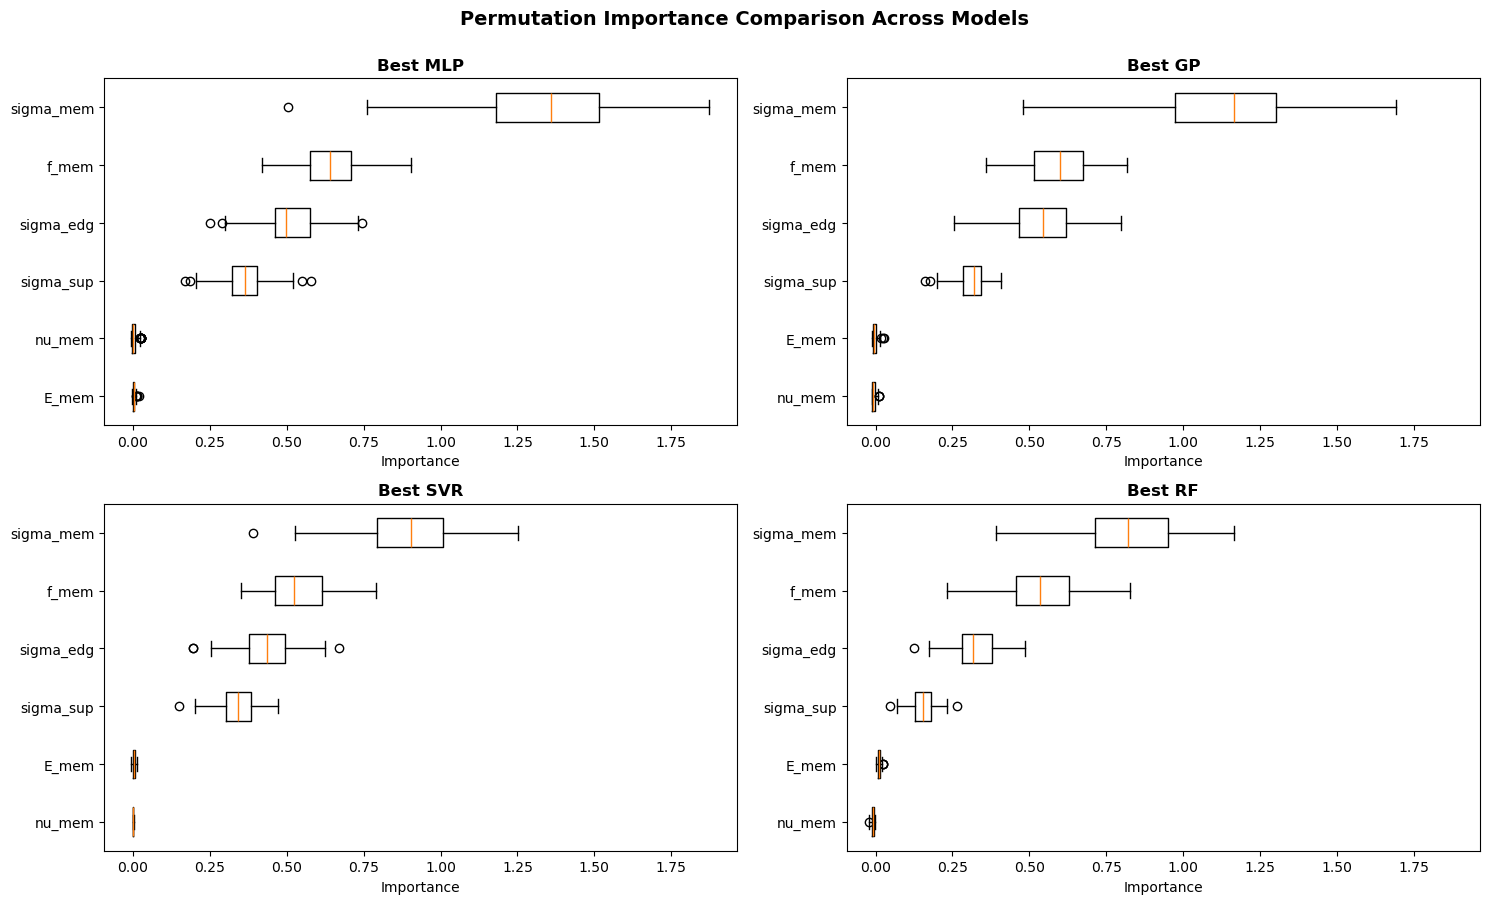

In [10]:
stacked_dataset = np.stack([perm_result1.importances, perm_result2.importances, perm_result3.importances, perm_result4.importances])
x_min, x_max = 0, np.max(stacked_dataset)
x_padding = 0.05 * (x_max - x_min)
x_min, x_max = x_min - x_padding, x_max + x_padding

fig, axes = plt.subplots(2, 2, figsize=(15, 9))

axes[0, 0].boxplot(perm_result1.importances[sorted_idx1].T, vert=False, tick_labels=[feature_names[i] for i in sorted_idx1])
axes[0, 0].set_title('Best MLP', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Importance')
axes[0, 0].set_xlim([x_min, x_max])

axes[0, 1].boxplot(perm_result2.importances[sorted_idx2].T, vert=False, tick_labels=[feature_names[i] for i in sorted_idx2])
axes[0, 1].set_title('Best GP', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Importance')
axes[0, 1].set_xlim([x_min, x_max])

axes[1, 0].boxplot(perm_result3.importances[sorted_idx3].T, vert=False, tick_labels=[feature_names[i] for i in sorted_idx3])
axes[1, 0].set_title('Best SVR', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Importance')
axes[1, 0].set_xlim([x_min, x_max])

axes[1, 1].boxplot(perm_result4.importances[sorted_idx4].T, vert=False, tick_labels=[feature_names[i] for i in sorted_idx4])
axes[1, 1].set_title('Best RF', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Importance')
axes[1, 1].set_xlim([x_min, x_max])

plt.suptitle('Permutation Importance Comparison Across Models', fontsize=14, fontweight='bold', y=1)
plt.tight_layout()
plt.savefig(path + 'permutation_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
def sample_lognorm(mean, std, size):
    s = np.sqrt(np.log(1 + (std**2) / (mean**2)))
    scale = mean**2 / math.sqrt(mean**2 + std**2)
    return stats.lognorm.rvs(s=s, scale=scale, size=size)

def sample_uniform(mean, std, size):
    loc = mean - np.sqrt(3) * std
    scale = 2 * np.sqrt(3) * std
    return stats.uniform.rvs(loc=loc, scale=scale, size=size)

def sample_gumble(mean, std, size):
    em_constant = round((1. - math.gamma(1 + 1.e-8)) * 1.e14) * 1.e-6
    scale = np.sqrt(6) * std / np.pi
    loc = mean - em_constant * scale
    return stats.gumbel_r.rvs(loc=loc, scale=scale, size=size)

np.random.seed(RANDOM_STATE)
size = 100000

E_mem_mean, E_mem_std = 0.6, 0.09
E_mem_samples = sample_lognorm(E_mem_mean, E_mem_std, size)

nu_mem_mean, nu_mem_std = 0.4, 0.0115
nu_mem_samples = sample_uniform(nu_mem_mean, nu_mem_std, size)

sigma_mem_mean, sigma_mem_std = 4, 0.8
sigma_mem_samples = sample_lognorm(sigma_mem_mean, sigma_mem_std, size)

sigma_edg_mean, sigma_edg_std = 353.678, 70.735
sigma_edg_samples = sample_lognorm(sigma_edg_mean, sigma_edg_std, size)

sigma_sup_mean, sigma_sup_std = 400.834, 80.166
sigma_sup_samples = sample_lognorm(sigma_sup_mean, sigma_sup_std, size)

f_mem_mean, f_mem_std = 0.4, 0.12
f_mem_samples = sample_gumble(f_mem_mean, f_mem_std, size)

# GET THE MODEL
X = df[['E_mem', 'nu_mem', 'sigma_mem', 'sigma_edg', 'sigma_sup', 'f_mem']].values
y = df['sigma_mem_max'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = MLPRegressor(hidden_layer_sizes=(64, 32), alpha=0.0001, learning_rate_init=0.01, max_iter=10000, random_state=RANDOM_STATE)
model.fit(X_scaled, y)

X_samples = np.column_stack((E_mem_samples, nu_mem_samples, sigma_mem_samples, sigma_edg_samples, sigma_sup_samples, f_mem_samples))
X_samples_scaled = scaler.transform(X_samples)
sigma_mem_max_samples = model.predict(X_samples_scaled)

In [12]:
desc_stats = []

# samples
data = sigma_mem_max_samples
mean_data = np.mean(data)
std_data = np.std(data, ddof=1)
skew_data = skew(data)
kurtosis_data = kurtosis(data)
q1_data = np.percentile(data, 25)
median_data = np.median(data)
q3_data = np.percentile(data, 75)
desc_stats.append(['samples (sigma_mem_max)', mean_data, std_data, skew_data, kurtosis_data, q1_data, median_data, q3_data])

# normal distribution
loc_norm, scale_norm = stats.norm.fit(data)
normal = stats.norm(loc=loc_norm, scale=scale_norm)
mean_norm = normal.mean()
std_norm = normal.std()
skew_norm = normal.stats(moments='s')
kurtosis_norm = normal.stats(moments='k')
q1_norm = normal.ppf(0.25)
median_norm = normal.median()
q3_norm = normal.ppf(0.75)
test_norm = kstest(data, stats.norm.cdf, args=(loc_norm, scale_norm))
desc_stats.append(['normal', mean_norm, std_norm, skew_norm, kurtosis_norm, q1_norm, median_norm, q3_norm, test_norm.statistic])

# lognormal distribution
sigma_lognorm, loc_lognorm, scale_lognorm = stats.lognorm.fit(data)
lognormal = stats.lognorm(s=sigma_lognorm, loc=loc_lognorm, scale=scale_lognorm)
mean_lognorm = lognormal.mean()
std_lognorm = lognormal.std()
skew_lognorm = lognormal.stats(moments='s')
kurtosis_lognorm = lognormal.stats(moments='k')
q1_lognorm = lognormal.ppf(0.25)
median_lognorm = lognormal.median()
q3_lognorm = lognormal.ppf(0.75)
test_lognorm = kstest(data, stats.lognorm.cdf, args=(sigma_lognorm, loc_lognorm, scale_lognorm))
desc_stats.append(['lognormal', mean_lognorm, std_lognorm, skew_lognorm, kurtosis_lognorm, q1_lognorm, median_lognorm, q3_lognorm, test_lognorm.statistic])

# gumbel distribution
loc_gumbel, scale_gumbel = stats.gumbel_r.fit(data)
gumbel = stats.gumbel_r(loc=loc_gumbel, scale=scale_gumbel)
mean_gumbel = gumbel.mean()
std_gumbel = gumbel.std()
skew_gumbel = gumbel.stats(moments='s')
kurtosis_gumbel = gumbel.stats(moments='k')
q1_gumbel = gumbel.ppf(0.25)
median_gumbel = gumbel.median()
q3_gumbel = gumbel.ppf(0.75)
test_gumbel = kstest(data, stats.gumbel_r.cdf, args=(loc_gumbel, scale_gumbel))
desc_stats.append(['gumbel', mean_gumbel, std_gumbel, skew_gumbel, kurtosis_gumbel, q1_gumbel, median_gumbel, q3_gumbel, test_gumbel.statistic])

# gamma distribution
a_gamma, loc_gamma, scale_gamma = stats.gamma.fit(data)
gamma = stats.gamma(a_gamma, loc=loc_gamma, scale=scale_gamma)
mean_gamma = gamma.mean()
std_gamma = gamma.std()
skew_gamma = gamma.stats(moments='s')
kurtosis_gamma = gamma.stats(moments='k')
q1_gamma = gamma.ppf(0.25)
median_gamma = gamma.median()
q3_gamma = gamma.ppf(0.75)
test_gamma = kstest(data, stats.gamma.cdf, args=(a_gamma, loc_gamma, scale_gamma))
desc_stats.append(['gamma', mean_gamma, std_gamma, skew_gamma, kurtosis_gamma, q1_gamma, median_gamma, q3_gamma, test_gamma.statistic])

# weibull distribution
c_weibull, loc_weibull, scale_weibull = stats.weibull_min.fit(data)
weibull = stats.weibull_min(c_weibull, loc=loc_weibull, scale=scale_weibull)
mean_weibull = weibull.mean()
std_weibull = weibull.std()
skew_weibull = weibull.stats(moments='s')
kurtosis_weibull = weibull.stats(moments='k')
q1_weibull = weibull.ppf(0.25)
median_weibull = weibull.median()
q3_weibull = weibull.ppf(0.75)
test_weibull = kstest(data, stats.weibull_min.cdf, args=(c_weibull, loc_weibull, scale_weibull))
desc_stats.append(['weibull', mean_weibull, std_weibull, skew_weibull, kurtosis_weibull, q1_weibull, median_weibull, q3_weibull, test_weibull.statistic])

desc_stats = pd.DataFrame(desc_stats, columns=['name', 'mean', 'std', 'skew', 'excess_kurtosis', 'q1', 'median', 'q3', 'ks_test'])
desc_stats

,name,mean,std,skew,excess_kurtosis,q1,median,q3,ks_test
0,samples (sigma_mem_max),4311.453826,375.287628,1.142923,3.523096,4024.728515,4278.851579,4528.373830,NaN
1,normal,4311.453826,375.285752,0.000000,0.000000,4058.327433,4311.453826,4564.580219,0.057821
2,lognormal,4312.215108,383.077548,1.218409,2.750838,4039.874839,4245.518857,4510.067315,0.041061
3,gumbel,4311.319616,379.093163,1.139547,2.400000,4044.161710,4249.040578,4508.967612,0.038881
4,gamma,4311.453806,387.195178,1.170456,2.054949,4026.890272,4237.647881,4516.262491,0.044673
5,weibull,4311.858129,373.088209,0.820859,0.659002,4027.777644,4255.320641,4535.305316,0.024832


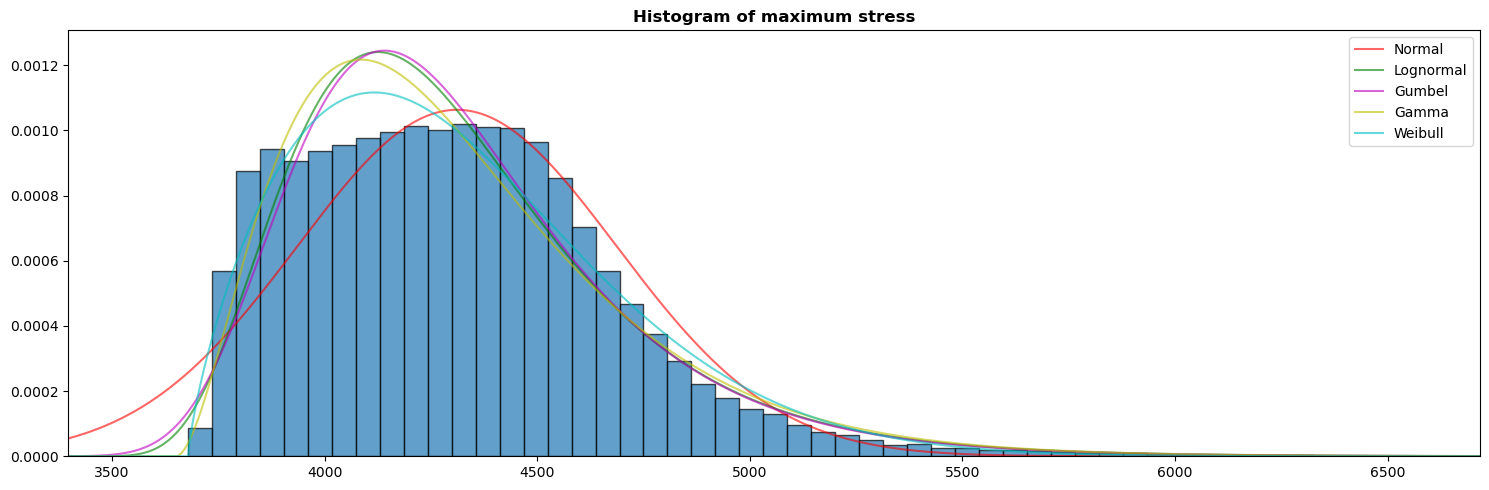

In [13]:
x_min, x_max = np.min(data), np.max(data)
x_padding = 0.05 * (x_max - x_min)
x_min, x_max = x_min - x_padding, x_max + x_padding
x = np.linspace(x_min, x_max, size)

plt.figure(figsize=(15, 5))
plt.hist(data, bins=100, density=True, alpha=0.7, edgecolor='black')
plt.plot(x, stats.norm.pdf(x, loc=loc_norm, scale=scale_norm), 'r-', alpha=0.6, label='Normal')
plt.plot(x, stats.lognorm.pdf(x, s=sigma_lognorm, loc=loc_lognorm, scale=scale_lognorm), 'g-', alpha=0.6, label='Lognormal')
plt.plot(x, stats.gumbel_r.pdf(x, loc=loc_gumbel, scale=scale_gumbel), 'm-', alpha=0.6, label='Gumbel')
plt.plot(x, stats.gamma.pdf(x, a_gamma, loc=loc_gamma, scale=scale_gamma), 'y-', alpha=0.6, label='Gamma')
plt.plot(x, stats.weibull_min.pdf(x, c_weibull, loc=loc_weibull, scale=scale_weibull), 'c-', alpha=0.6, label='Weibull')
plt.title('Histogram of maximum stress', fontsize=12, fontweight='bold')
plt.xlim([x_min, 0.7*x_max])
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(path + 'histogram_max_stress.png', dpi=300, bbox_inches='tight')
plt.show()

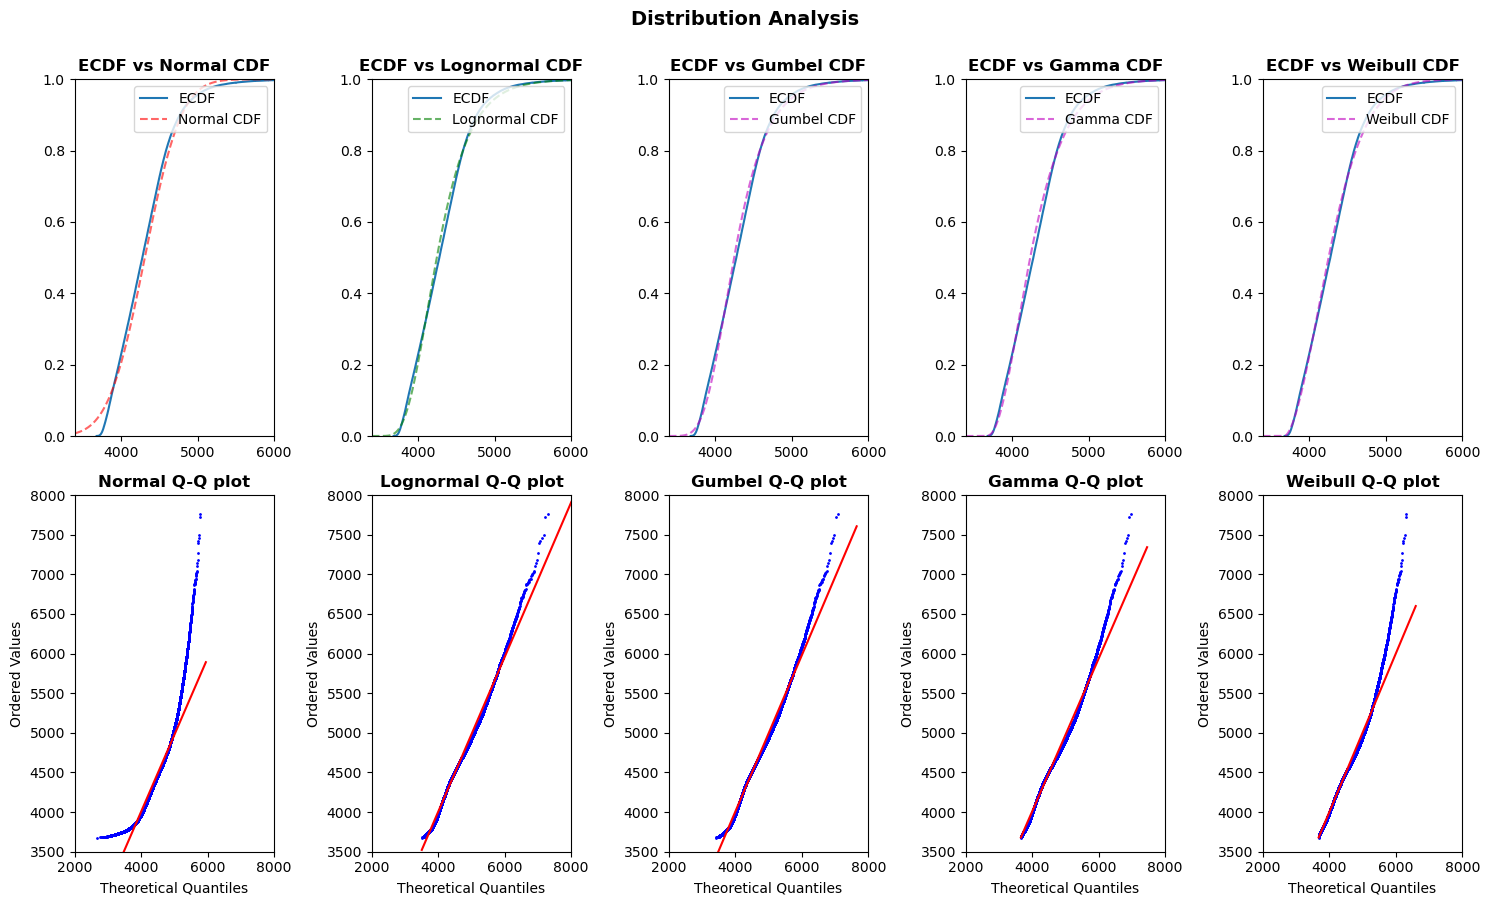

In [20]:
fig = plt.figure(figsize=(15, 9))
spec = fig.add_gridspec(2, 5)

ax00 = fig.add_subplot(spec[0, 0])
ax00.ecdf(data, label='ECDF')
ax00.plot(x, stats.norm.cdf(x, loc=loc_norm, scale=scale_norm), 'r--', alpha=0.6, label='Normal CDF')
ax00.set_title('ECDF vs Normal CDF', fontsize=12, fontweight='bold')
ax00.set_xlim([x_min, 6000])
ax00.legend(loc=1)

ax01 = fig.add_subplot(spec[0, 1])
ax01.ecdf(data, label='ECDF')
ax01.plot(x, stats.lognorm.cdf(x, s=sigma_lognorm, loc=loc_lognorm, scale=scale_lognorm), 'g--', alpha=0.6, label='Lognormal CDF')
ax01.set_title('ECDF vs Lognormal CDF', fontsize=12, fontweight='bold')
ax01.set_xlim([x_min, 6000])
ax01.legend(loc=1)

ax02 = fig.add_subplot(spec[0, 2])
ax02.ecdf(data, label='ECDF')
ax02.plot(x, stats.gumbel_r.cdf(x, loc=loc_gumbel, scale=scale_gumbel), 'm--', alpha=0.6, label='Gumbel CDF')
ax02.set_title('ECDF vs Gumbel CDF', fontsize=12, fontweight='bold')
ax02.set_xlim([x_min, 6000])
ax02.legend(loc=1)

ax03 = fig.add_subplot(spec[0, 3])
ax03.ecdf(data, label='ECDF')
ax03.plot(x, stats.gamma.cdf(x, a=a_gamma, loc=loc_gamma, scale=scale_gamma), 'm--', alpha=0.6, label='Gamma CDF')
ax03.set_title('ECDF vs Gamma CDF', fontsize=12, fontweight='bold')
ax03.set_xlim([x_min, 6000])
ax03.legend(loc=1)

ax04 = fig.add_subplot(spec[0, 4])
ax04.ecdf(data, label='ECDF')
ax04.plot(x, stats.weibull_min.cdf(x, c=c_weibull, loc=loc_weibull, scale=scale_weibull), 'm--', alpha=0.6, label='Weibull CDF')
ax04.set_title('ECDF vs Weibull CDF', fontsize=12, fontweight='bold')
ax04.set_xlim([x_min, 6000])
ax04.legend(loc=1)

ax10 = fig.add_subplot(spec[1, 0])
res = stats.probplot(data, dist=stats.norm, sparams=(loc_norm, scale_norm), plot=ax10)
ax10.get_lines()[0].set_markersize(1)
ax10.set_xlabel('')
ax10.set_ylabel('')
ax10.set_title('Normal Q-Q plot', fontsize=12, fontweight='bold')

ax11 = fig.add_subplot(spec[1, 1])
res = stats.probplot(data, dist=stats.lognorm, sparams=(sigma_lognorm, loc_lognorm, scale_lognorm), plot=ax11)
ax11.get_lines()[0].set_markersize(1)
ax11.set_xlabel('')
ax11.set_ylabel('')
ax11.set_title('Lognormal Q-Q plot', fontsize=12, fontweight='bold')

ax12 = fig.add_subplot(spec[1, 2])
res = stats.probplot(data, dist=stats.gumbel_r, sparams=(loc_gumbel, scale_gumbel), plot=ax12)
ax12.get_lines()[0].set_markersize(1)
ax12.set_xlabel('')
ax12.set_ylabel('')
ax12.set_title('Gumbel Q-Q plot', fontsize=12, fontweight='bold')

ax13 = fig.add_subplot(spec[1, 3])
res = stats.probplot(data, dist=stats.gamma, sparams=(a_gamma, loc_gamma, scale_gamma), plot=ax13)
ax13.get_lines()[0].set_markersize(1)
ax13.set_xlabel('')
ax13.set_ylabel('')
ax13.set_title('Gamma Q-Q plot', fontsize=12, fontweight='bold')

ax14 = fig.add_subplot(spec[1, 4])
res = stats.probplot(data, dist=stats.weibull_min, sparams=(c_weibull, loc_weibull, scale_weibull), plot=ax14)
ax14.get_lines()[0].set_markersize(1)
ax14.set_xlabel('')
ax14.set_ylabel('')
ax14.set_title('Weibull Q-Q plot', fontsize=12, fontweight='bold')

# Q-Q plots generally require equal scaling for the 45-degree line comparison
for ax in [ax10, ax11, ax12, ax13, ax14]:
    ax.get_lines()[0].set_markersize(1) # Theoretical vs Sample
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Ordered Values')
    # Optional: Ensure x and y limits are the same for the Q-Q line
    ax.set_xlim([2000, 8000])
    ax.set_ylim([3500, 8000])

plt.suptitle('Distribution Analysis', fontsize=14, fontweight='bold', y=1)
plt.tight_layout()
plt.savefig(path + 'distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()